<a href="https://colab.research.google.com/github/nargisk16/Project_P552_Hourly_Energy_Cons_Forecast/blob/main/P_552_Hourly_Energy_Consumption_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hourly Energy Consumption Forecast**

In [ ]:
import pandas as pd

# Load the uploaded CSV file
#file_path = "/mnt/data/PJMW_hourly.csv"
df = pd.read_csv("/content/PJMW_hourly.csv")

# Display basic info and first few rows
df.info(), df.head()

# Print the DataFrame (or a portion of it)
print(df.head()) # Print the first 5 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  143206 non-null  object 
 1   PJMW_MW   143206 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB
              Datetime  PJMW_MW
0  2002-12-31 01:00:00   5077.0
1  2002-12-31 02:00:00   4939.0
2  2002-12-31 03:00:00   4885.0
3  2002-12-31 04:00:00   4857.0
4  2002-12-31 05:00:00   4930.0


The dataset contains hourly energy consumption data (PJMW_MW) from December 2002 to roughly mid-2019, with a total of 143,206 hourly records.

Columns:
Datetime: Timestamps in hourly intervals.

PJMW_MW: Energy consumption in megawatts (MW).


**Let’s start with Step 1: Preprocessing and creating a train-test split. **

In [ ]:
# Convert 'Datetime' to datetime type and set as index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Sort the index (just in case)
df.sort_index(inplace=True)

# Check the date range
date_range = df.index.min(), df.index.max()

# Split last 1 year of data for test set
train_df = df[df.index < '2018-06-01']
test_df = df[df.index >= '2018-06-01']

date_range, train_df.shape, test_df.shape


((Timestamp('2002-04-01 01:00:00'), Timestamp('2018-08-03 00:00:00')),
 (141693, 1),
 (1513, 1))

2. Explore Trends
Hourly trends

Holidays & seasonality

Long-term trends

/tmp/ipython-input-10-2987025295.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df['PJMW_MW'].resample('M').mean()


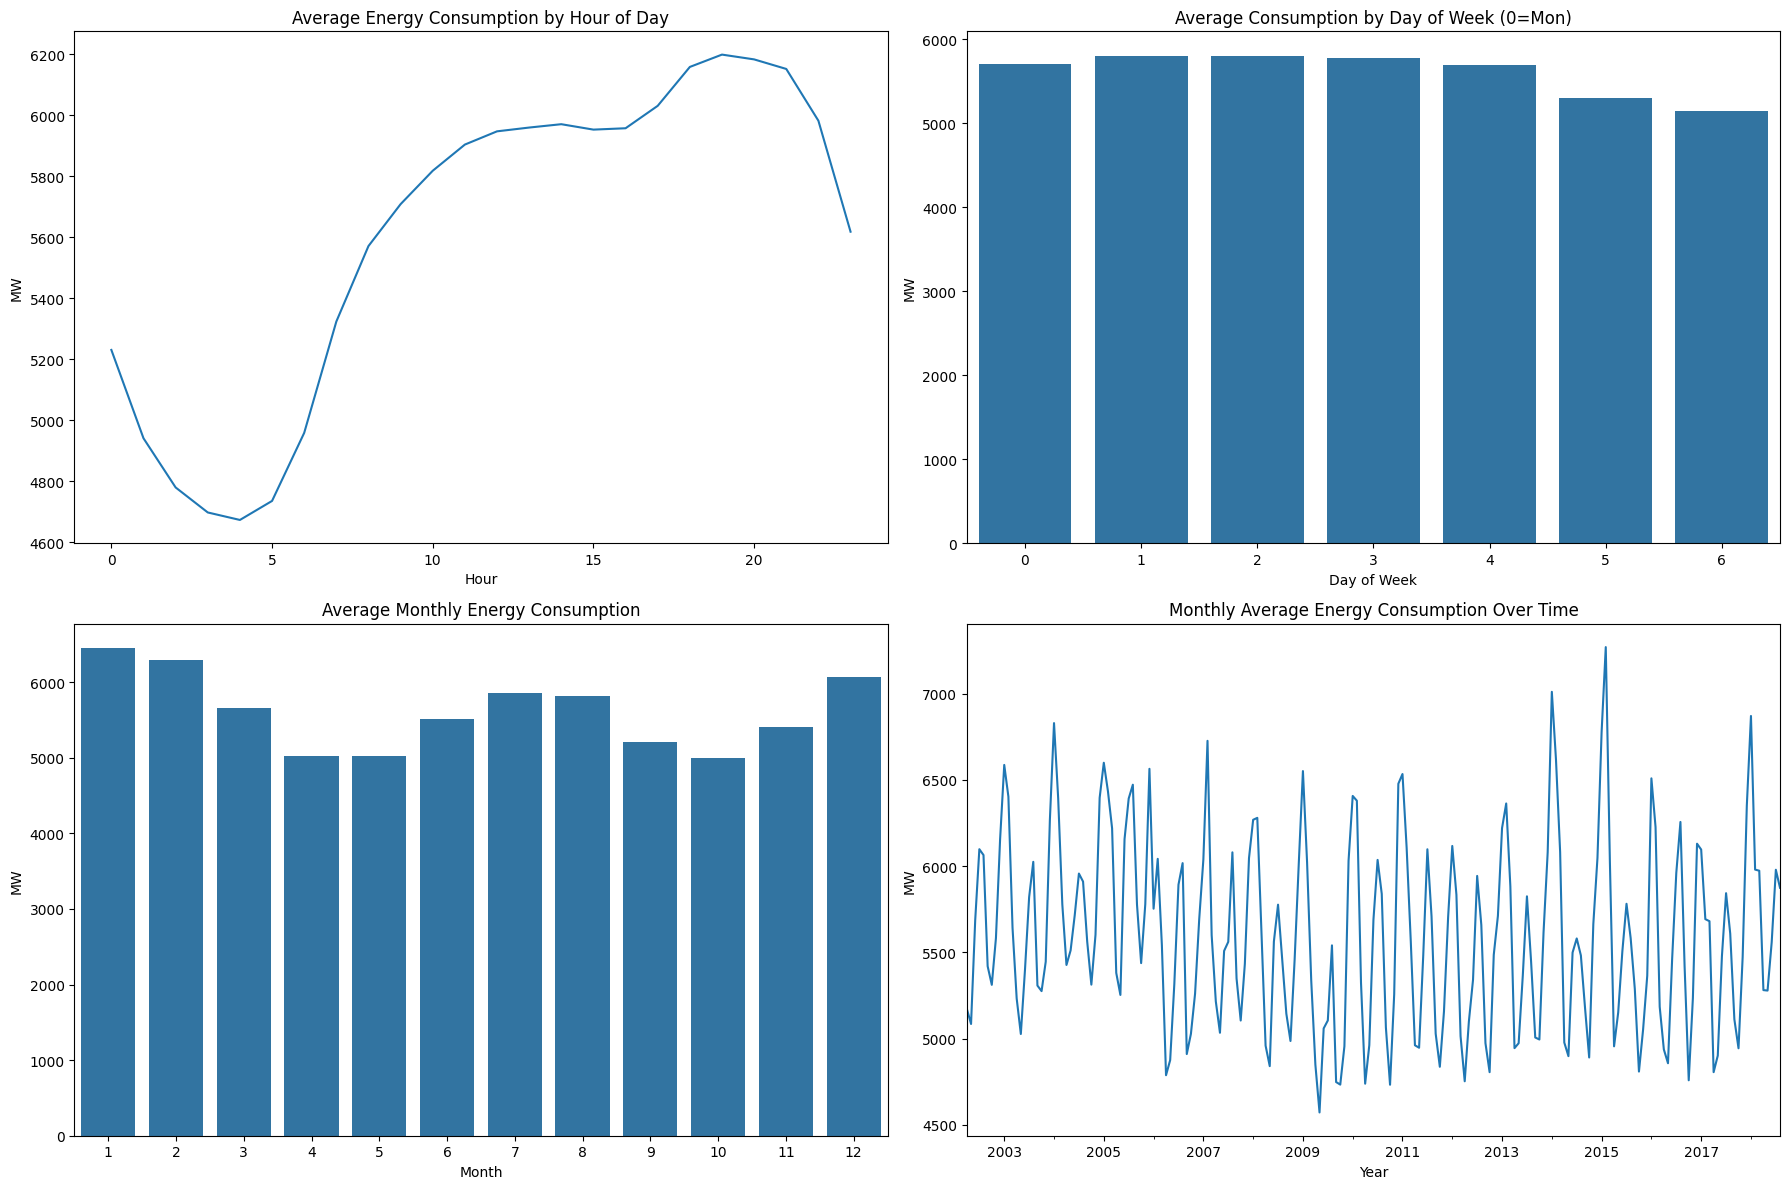

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Resample for long-term trends (daily, monthly)
daily_df = df['PJMW_MW'].resample('D').mean()
monthly_df = df['PJMW_MW'].resample('M').mean()

# Extract hour, day, month for grouping
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek  # 0=Monday
df['month'] = df.index.month
df['year'] = df.index.year

# Prepare data for plotting
hourly_avg = df.groupby('hour')['PJMW_MW'].mean()
weekday_avg = df.groupby('dayofweek')['PJMW_MW'].mean()
monthly_avg = df.groupby('month')['PJMW_MW'].mean()

# Plotting
plt.figure(figsize=(18, 12))

# Hourly pattern
plt.subplot(2, 2, 1)
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values)
plt.title("Average Energy Consumption by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("MW")

# Weekday pattern
plt.subplot(2, 2, 2)
sns.barplot(x=weekday_avg.index, y=weekday_avg.values)
plt.title("Average Consumption by Day of Week (0=Mon)")
plt.xlabel("Day of Week")
plt.ylabel("MW")

# Monthly pattern
plt.subplot(2, 2, 3)
sns.barplot(x=monthly_avg.index, y=monthly_avg.values)
plt.title("Average Monthly Energy Consumption")
plt.xlabel("Month")
plt.ylabel("MW")

# Long-term monthly trend
plt.subplot(2, 2, 4)
monthly_df.plot(ax=plt.gca())
plt.title("Monthly Average Energy Consumption Over Time")
plt.xlabel("Year")
plt.ylabel("MW")

plt.tight_layout()
plt.show()


3. Understand Seasonal Changes
Compare trends for Summer vs Winter

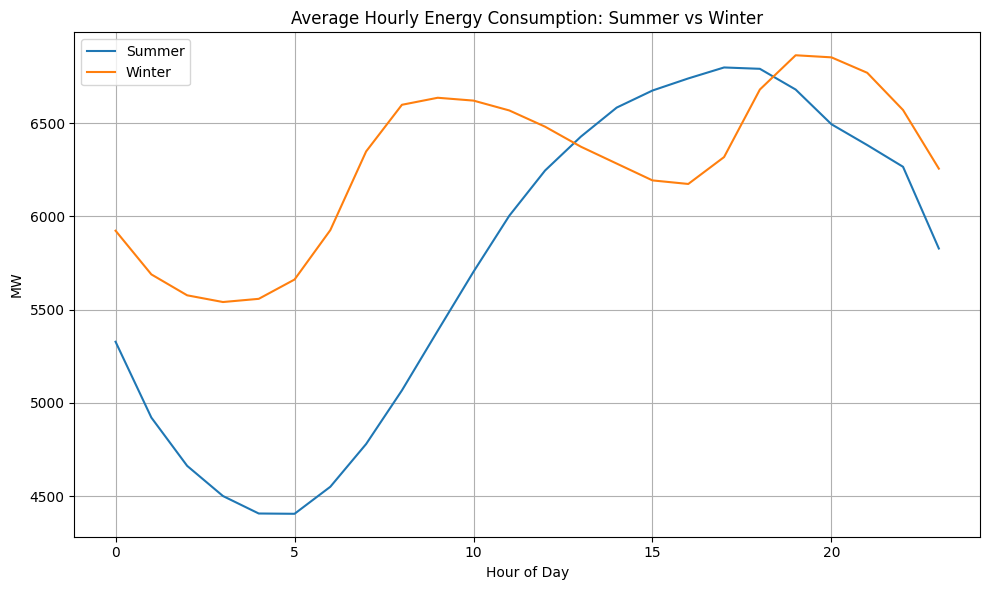

In [ ]:
# Filter for Summer (June, July, August) and Winter (December, January, February)
summer_df = df[df['month'].isin([6, 7, 8])]
winter_df = df[df['month'].isin([12, 1, 2])]

# Compute hourly average consumption for each season
summer_hourly = summer_df.groupby('hour')['PJMW_MW'].mean()
winter_hourly = winter_df.groupby('hour')['PJMW_MW'].mean()

# Plot comparison
plt.figure(figsize=(10, 6))
sns.lineplot(x=summer_hourly.index, y=summer_hourly.values, label='Summer')
sns.lineplot(x=winter_hourly.index, y=winter_hourly.values, label='Winter')
plt.title("Average Hourly Energy Consumption: Summer vs Winter")
plt.xlabel("Hour of Day")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


4. Model Building & Forecasting
Use models like SARIMA, or XGBoost

Forecast the next 30 days

Aggregate to daily data and prepare for modeling.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Aggregate to daily level
daily_df = df['PJMW_MW'].resample('D').mean()

# Train-test split (using same split as before)
train_daily = daily_df[:'2018-05-31']
test_daily = daily_df['2018-06-01':'2018-06-30']

# Fit a SARIMA model (seasonal order estimated based on common patterns: daily ~ 7-day weekly seasonality)
sarima_model = SARIMAX(train_daily, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_result = sarima_model.fit(disp=False)

# Forecast next 30 days
forecast = sarima_result.get_forecast(steps=30)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Prepare data for plotting
forecast_index = test_daily.index

plt.figure(figsize=(12, 6))
plt.plot(train_daily[-60:], label='Train (last 60 days)')
plt.plot(test_daily, label='Actual (June 2018)', color='black')
plt.plot(forecast_index, forecast_mean, label='Forecast (SARIMA)', color='red')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title("30-Day Energy Consumption Forecast (SARIMA)")
plt.xlabel("Date")
plt.ylabel("MW")
plt.legend()
plt.tight_layout()
plt.show()


✅ SARIMA Model for 30-Day Forecast

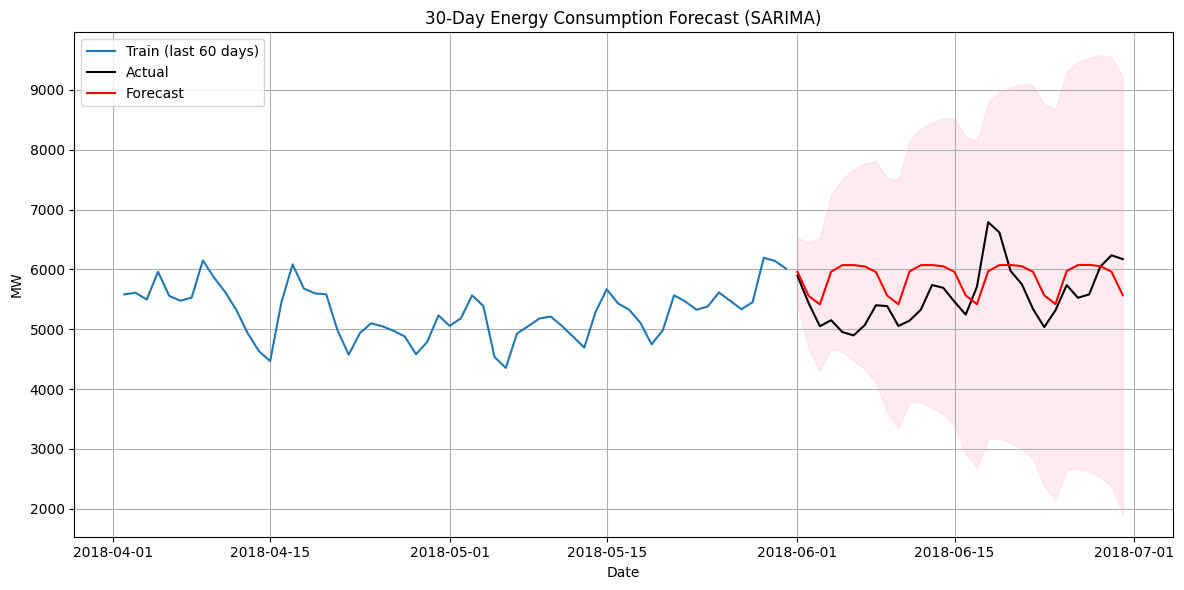

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('PJMW_hourly.csv', parse_dates=['Datetime'], index_col='Datetime')
df = df.resample('D').mean()  # Daily average

# Train-test split
train = df[:'2018-05-31']
test = df['2018-06-01':'2018-06-30']

# Fit SARIMA model
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
results = model.fit()

# Forecast
forecast = results.get_forecast(steps=30)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train[-60:], label='Train (last 60 days)')
plt.plot(test, label='Actual', color='black')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('30-Day Energy Consumption Forecast (SARIMA)')
plt.xlabel('Date')
plt.ylabel('MW')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Python Code: Holidays vs. Non-Holidays


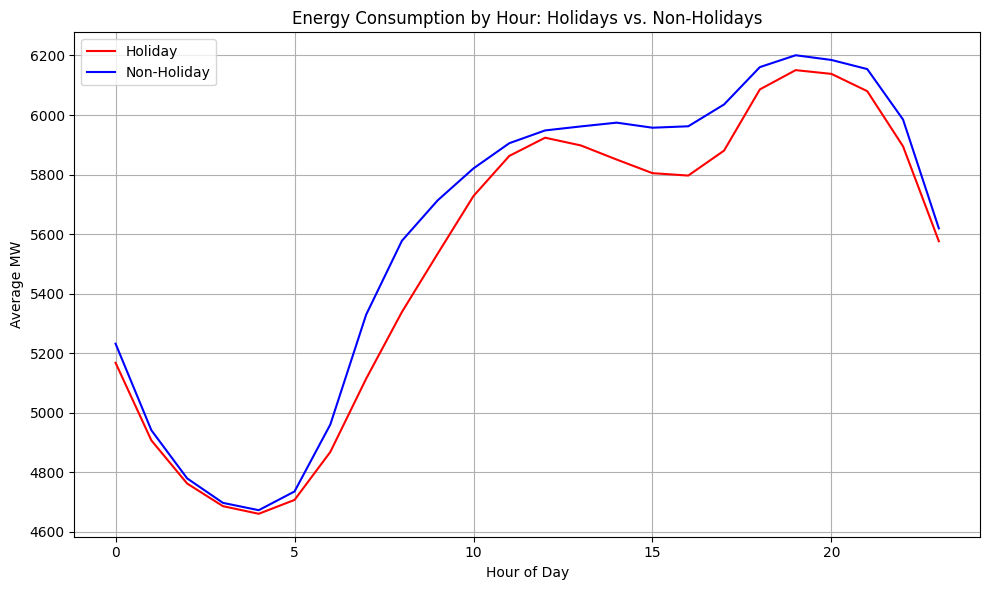

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Load and resample data
df = pd.read_csv('PJMW_hourly.csv', parse_dates=['Datetime'], index_col='Datetime')
df['hour'] = df.index.hour

# Add holiday flag
holidays = calendar().holidays(start=df.index.min(), end=df.index.max())
df['is_holiday'] = df.index.normalize().isin(holidays)

# Group by hour for comparison
holiday_avg = df[df['is_holiday']].groupby('hour')['PJMW_MW'].mean()
nonholiday_avg = df[~df['is_holiday']].groupby('hour')['PJMW_MW'].mean()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x=holiday_avg.index, y=holiday_avg.values, label='Holiday', color='red')
sns.lineplot(x=nonholiday_avg.index, y=nonholiday_avg.values, label='Non-Holiday', color='blue')
plt.title('Energy Consumption by Hour: Holidays vs. Non-Holidays')
plt.xlabel('Hour of Day')
plt.ylabel('Average MW')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Here's the heatmap showing standardized hourly energy usage across different days. Each cell represents the z-score (standardized value) of energy consumption for a particular hour on a specific date:

Red areas indicate higher-than-average energy usage.

Blue areas show lower-than-average usage.

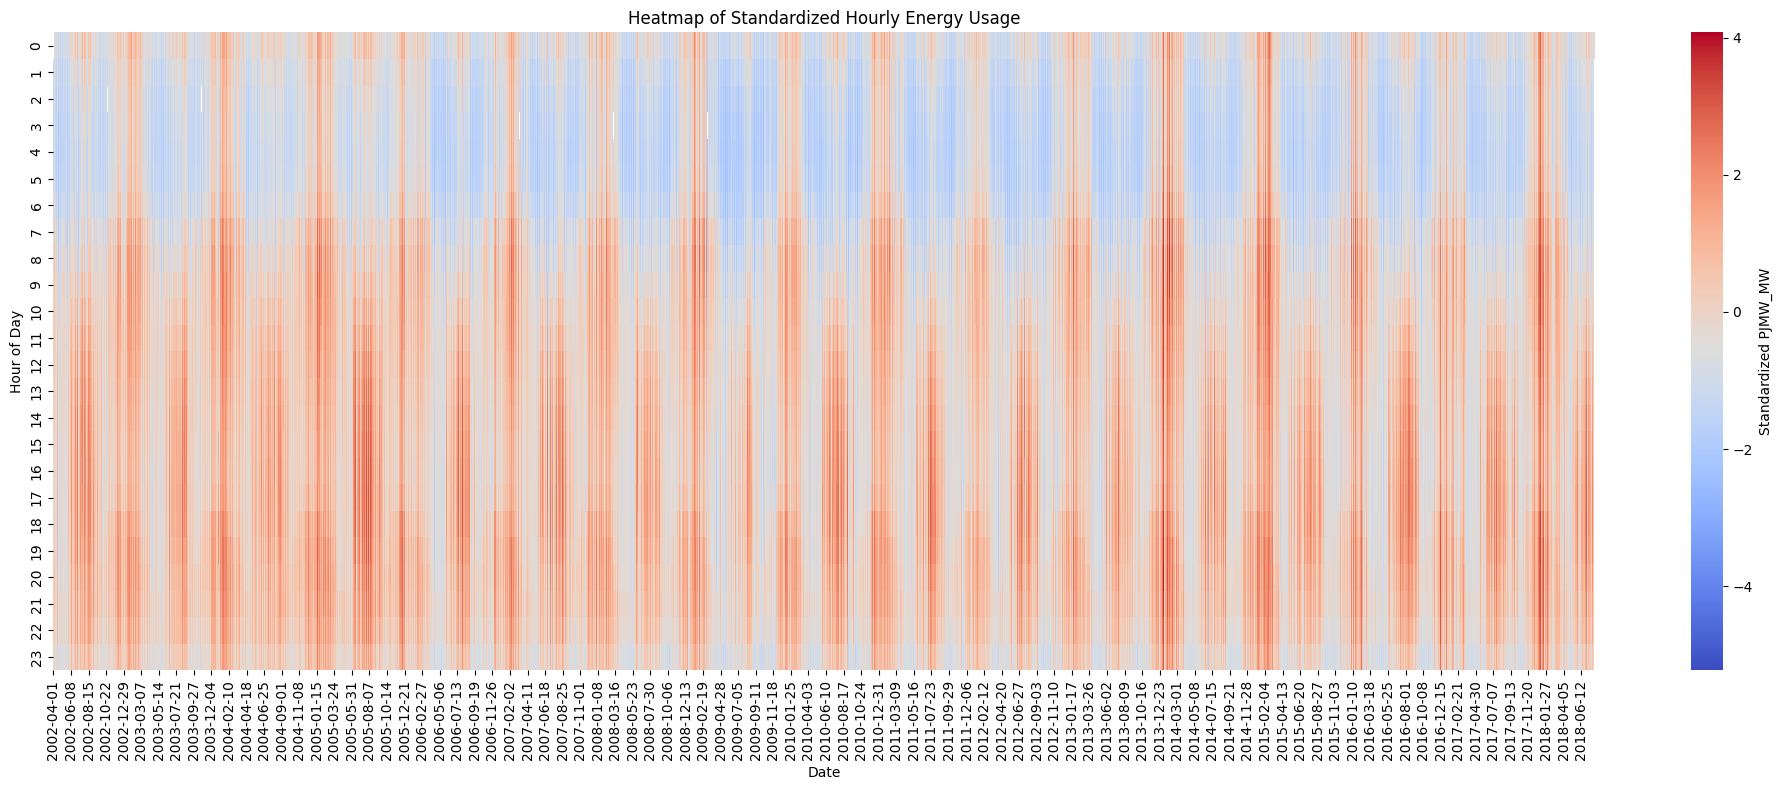

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/content/PJMW_hourly.csv")

# Convert 'Datetime' to datetime object
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Standardize the 'PJMW_MW' column
scaler = StandardScaler()
df['PJMW_MW_Standardized'] = scaler.fit_transform(df[['PJMW_MW']])

# Create a new DataFrame for heatmap: average standardized values by hour and date
df['Date'] = df['Datetime'].dt.date
df['Hour'] = df['Datetime'].dt.hour

pivot_table = df.pivot_table(index='Hour', columns='Date', values='PJMW_MW_Standardized')

# Plot heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(pivot_table, cmap='coolwarm', cbar_kws={'label': 'Standardized PJMW_MW'})
plt.title('Heatmap of Standardized Hourly Energy Usage')
plt.xlabel('Date')
plt.ylabel('Hour of Day')
plt.tight_layout()
plt.show()

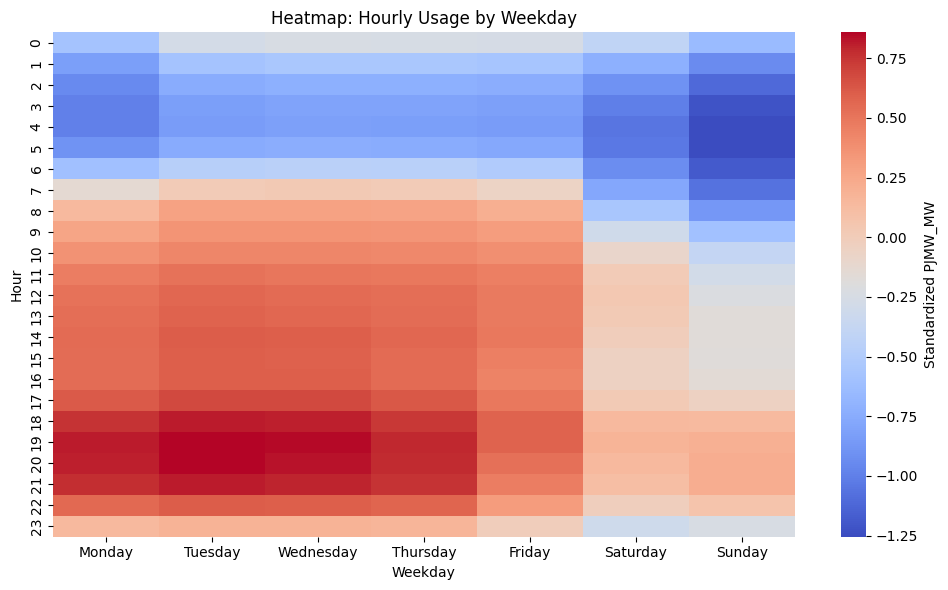

In [ ]:
# 1. Grouped Heatmap by Weekday vs Hour
df['Weekday'] = df['Datetime'].dt.day_name()

weekday_hour_pivot = df.pivot_table(index='Hour', columns='Weekday', values='PJMW_MW_Standardized', aggfunc='mean')
# Reorder weekdays
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_hour_pivot = weekday_hour_pivot[ordered_days]

plt.figure(figsize=(10, 6))
sns.heatmap(weekday_hour_pivot, cmap='coolwarm', cbar_kws={'label': 'Standardized PJMW_MW'})
plt.title('Heatmap: Hourly Usage by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Hour')
plt.tight_layout()
plt.show()


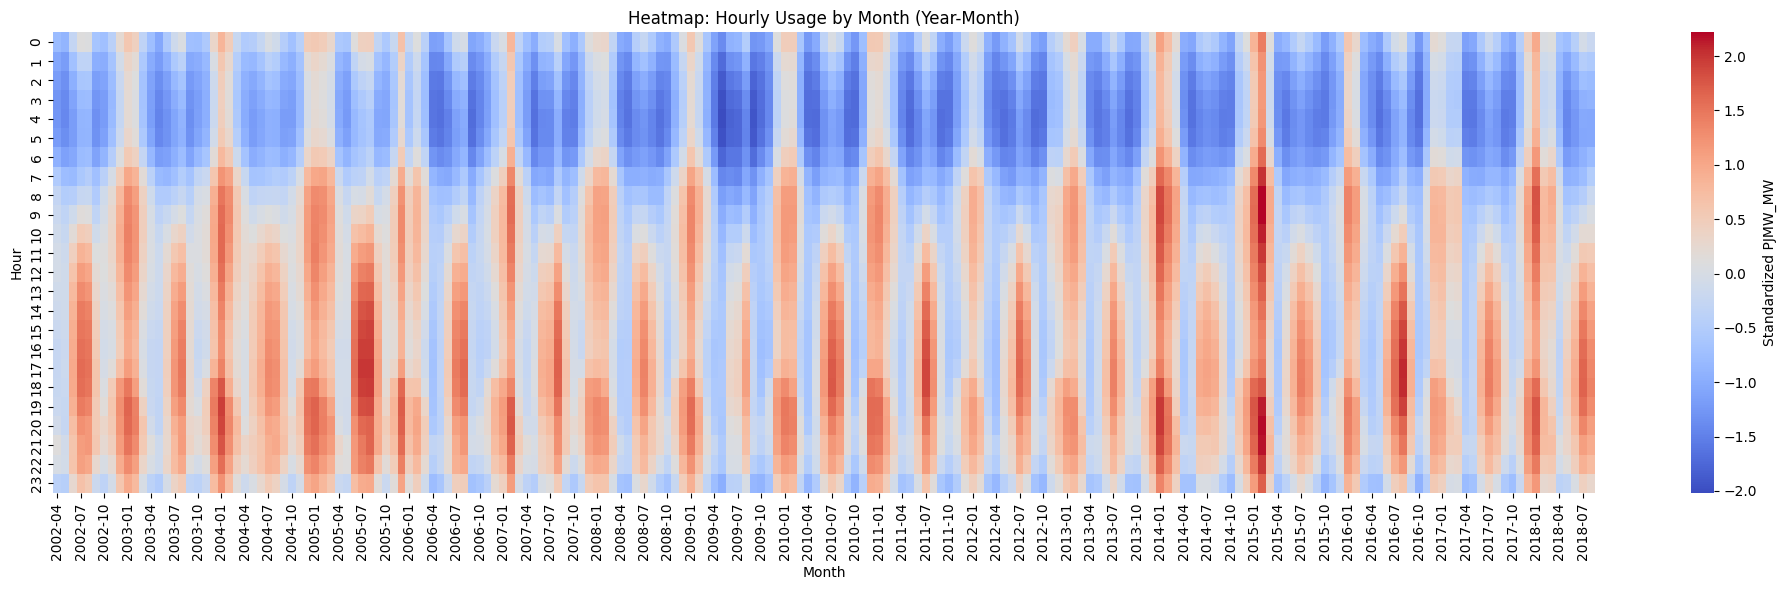

In [ ]:
# 2. Monthly Average Heatmap
df['Month'] = df['Datetime'].dt.month_name()
df['Year'] = df['Datetime'].dt.year
df['Year-Month'] = df['Datetime'].dt.to_period('M')

month_hour_pivot = df.pivot_table(index='Hour', columns='Year-Month', values='PJMW_MW_Standardized', aggfunc='mean')

plt.figure(figsize=(20, 6))
sns.heatmap(month_hour_pivot, cmap='coolwarm', cbar_kws={'label': 'Standardized PJMW_MW'})
plt.title('Heatmap: Hourly Usage by Month (Year-Month)')
plt.xlabel('Month')
plt.ylabel('Hour')
plt.tight_layout()
plt.show()


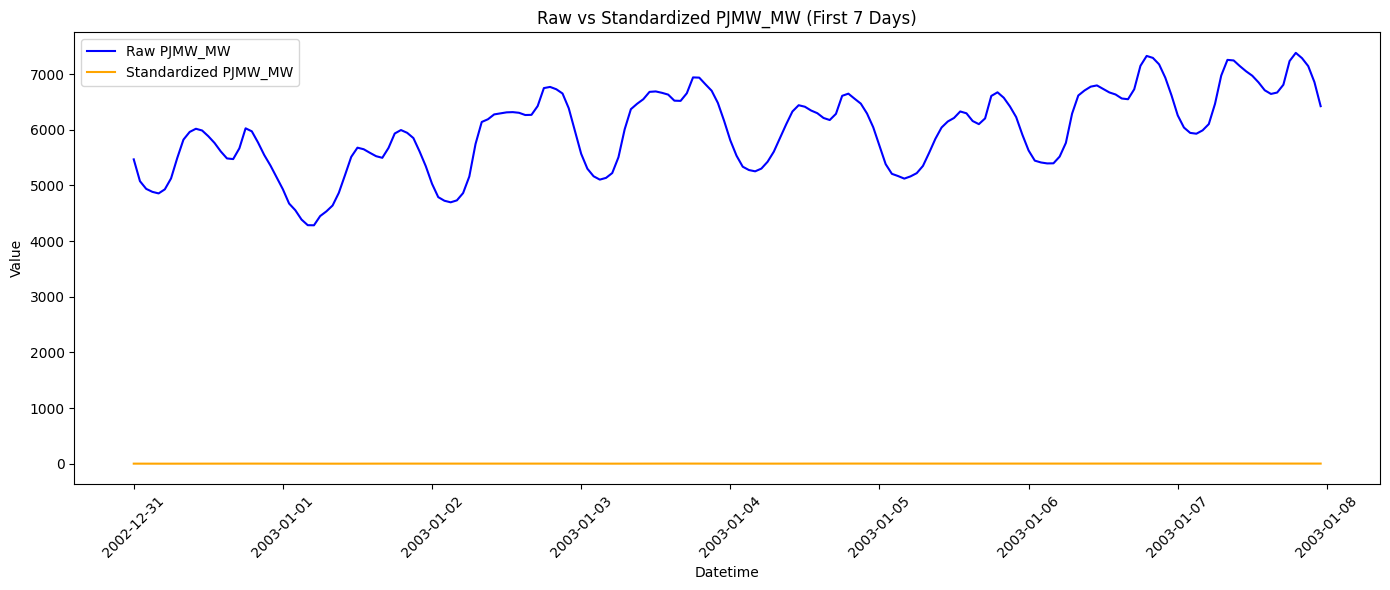

In [ ]:
# Sample a portion of the data for clearer line plot (e.g., first 7 days)
sample_df = df.set_index('Datetime')
sample_df.sort_index(inplace=True) # Sort the index
sample_df = sample_df.loc['2002-12-31':'2003-01-07']

# Plot raw and standardized values
plt.figure(figsize=(14, 6))
plt.plot(sample_df.index, sample_df['PJMW_MW'], label='Raw PJMW_MW', color='blue')
plt.plot(sample_df.index, sample_df['PJMW_MW_Standardized'], label='Standardized PJMW_MW', color='orange')
plt.title('Raw vs Standardized PJMW_MW (First 7 Days)')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()